In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.cm as cm
from matplotlib import rcParams
from collections import Counter
from nltk.tokenize import RegexpTokenizer
import re
import string
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, TextVectorization
from keras.models import Model
from keras.optimizers import RMSprop
from keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [4]:
data = pd.read_csv('training.1600000.processed.noemoticon.csv',
                   encoding='ISO-8859-1', engine='python')
data.columns = ['label', 'time', 'date', 'query', 'username', 'text']
data.head()

,label,time,date,query,username,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [5]:
data.tail()

,label,time,date,query,username,text
1599994,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599995,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599996,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599997,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599998,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


In [6]:
len(data)

1599999

In [7]:
data.shape

(1599999, 6)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   label     1599999 non-null  int64 
 1   time      1599999 non-null  int64 
 2   date      1599999 non-null  object
 3   query     1599999 non-null  object
 4   username  1599999 non-null  object
 5   text      1599999 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [9]:
data.dtypes

label        int64
time         int64
date        object
query       object
username    object
text        object
dtype: object

In [10]:
np.sum(data.isnull().any(axis=1))

np.int64(0)

In [11]:
data = data[['text', 'label']]

In [12]:
data['label'][data['label'] == 4] = 1

In [13]:
data_pos = data[data['label'] == 1]
data_neg = data[data['label'] == 0]

In [14]:
data_pos = data_pos.iloc[:int(20000)]
data_neg = data_neg.iloc[:int(20000)]

In [15]:
data = pd.concat([data_pos, data_neg])

In [16]:
data['text'] = data['text'].str.lower()

In [17]:
data.head()

,text,label
799999,i love @health4uandpets u guys r the best!!,1
800000,im meeting up with one of my besties tonight! ...,1
800001,"@darealsunisakim thanks for the twitter add, s...",1
800002,being sick can be really cheap when it hurts t...,1
800003,@lovesbrooklyn2 he has that effect on everyone,1


In [18]:
stopwords_list = stopwords.words('english')

In [56]:
stopwords??

Type:           WordListCorpusReader
String form:    <WordListCorpusReader in 'C:\\Users\\ASUS\\AppData\\Roaming\\nltk_data\\corpora\\stopwords'>
File:           c:\users\asus\appdata\roaming\python\python313\site-packages\nltk\corpus\reader\wordlist.py
Source:        
class WordListCorpusReader(CorpusReader):
    """
    List of words, one per line.  Blank lines are ignored.
    """

    def words(self, fileids=None, ignore_lines_startswith="\n"):
        return [
            line
            for line in line_tokenize(self.raw(fileids))
            if not line.startswith(ignore_lines_startswith)
        ]
Init docstring:
:type root: PathPointer or str
:param root: A path pointer identifying the root directory for
    this corpus.  If a string is specified, then it will be
    converted to a ``PathPointer`` automatically.
:param fileids: A list of the files that make up this corpus.
    This list can either be specified explicitly, as a list of
    strings; or implicitly, as a regular 

In [19]:
", ".join(stopwords.words('english'))

"a, about, above, after, again, against, ain, all, am, an, and, any, are, aren, aren't, as, at, be, because, been, before, being, below, between, both, but, by, can, couldn, couldn't, d, did, didn, didn't, do, does, doesn, doesn't, doing, don, don't, down, during, each, few, for, from, further, had, hadn, hadn't, has, hasn, hasn't, have, haven, haven't, having, he, he'd, he'll, her, here, hers, herself, he's, him, himself, his, how, i, i'd, if, i'll, i'm, in, into, is, isn, isn't, it, it'd, it'll, it's, its, itself, i've, just, ll, m, ma, me, mightn, mightn't, more, most, mustn, mustn't, my, myself, needn, needn't, no, nor, not, now, o, of, off, on, once, only, or, other, our, ours, ourselves, out, over, own, re, s, same, shan, shan't, she, she'd, she'll, she's, should, shouldn, shouldn't, should've, so, some, such, t, than, that, that'll, the, their, theirs, them, themselves, then, there, these, they, they'd, they'll, they're, they've, this, those, through, to, too, under, until, up, 

In [20]:
STOPWORDS = set(stopwords.words('english'))
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
data['text'] = data['text'].apply(lambda text: cleaning_stopwords(text))
data['text'].head()

799999                love @health4uandpets u guys r best!!
800000    im meeting one besties tonight! cant wait!! - ...
800001    @darealsunisakim thanks twitter add, sunisa! g...
800002    sick really cheap hurts much eat real food plu...
800003                      @lovesbrooklyn2 effect everyone
Name: text, dtype: object

In [21]:
english_punctuations = string.punctuation
punctuation_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuation_list)
    return text.translate(translator)

In [22]:
data['text'] = data['text'].apply(lambda x: cleaning_punctuations(x))
data['text'].tail()

19995                                     one day holidays
19996                     feeling right  hate damn humprey
19997    geezi hv read whole book personality types emb...
19998     threw sign donnie bent get thingee made sad face
19999    heather2711 good thing find none ones like com...
Name: text, dtype: object

In [23]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)\1+','r\1', text)

In [24]:
data['text'] = data['text'].apply(lambda x: cleaning_repeating_char(x))
data['text'].tail()

19995                                     one day holidays
19996                     frling rightrhate damn humprey
19997    grzi hv read whole brk personality types emb...
19998     threw sign dorie bent get thingr made sad face
19999    heather27r grd thing find none ones like com...
Name: text, dtype: object

In [25]:
def cleaning_email(data):
    return re.sub('@[^\s]+', ' ', data)

In [26]:
data['text'] = data['text'].apply(lambda x: cleaning_email(x))
data['text'].tail()

19995                                     one day holidays
19996                     frling rightrhate damn humprey
19997    grzi hv read whole brk personality types emb...
19998     threw sign dorie bent get thingr made sad face
19999    heather27r grd thing find none ones like com...
Name: text, dtype: object

In [27]:
def cleaning_URLs(data):
    return re.sub('((www\.[^\s]+)|(https?://[^\s]))', ' ', data)

In [28]:
data['text'] = data['text'].apply(lambda x: cleaning_URLs(x))
data['text'].tail()

19995                                     one day holidays
19996                     frling rightrhate damn humprey
19997    grzi hv read whole brk personality types emb...
19998     threw sign dorie bent get thingr made sad face
19999    heather27r grd thing find none ones like com...
Name: text, dtype: object

In [29]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)

In [30]:
data['text'] = data['text'].apply(lambda x: cleaning_numbers(x))
data['text'].tail()

19995                                     one day holidays
19996                     frling rightrhate damn humprey
19997    grzi hv read whole brk personality types emb...
19998     threw sign dorie bent get thingr made sad face
19999    heatherr grd thing find none ones like come ...
Name: text, dtype: object

In [31]:
tokenizer = RegexpTokenizer(r'\w+')
data['text'] = data['text'].apply(tokenizer.tokenize)

In [32]:
data['text'].head()

799999             [love, healthuandpets, u, guys, r, best]
800000    [im, mr, ting, one, besties, tonight, cant, wa...
800001    [darealsunisakim, thanks, twir, er, ar, sunisa...
800002    [sick, rear, y, cheap, hurts, much, eat, real,...
800003                  [lovesbrr, klyn, er, ect, everyone]
Name: text, dtype: object

In [58]:
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return text

data['text'] = data['text'].apply(lambda x: stemming_on_text(x))

In [34]:
data.head()

,text,label
799999,"[love, healthuandpets, u, guys, r, best]",1
800000,"[im, mr, ting, one, besties, tonight, cant, wa...",1
800001,"[darealsunisakim, thanks, twir, er, ar, sunisa...",1
800002,"[sick, rear, y, cheap, hurts, much, eat, real,...",1
800003,"[lovesbrr, klyn, er, ect, everyone]",1


In [59]:
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return text

data['text'] = data['text'].apply(lambda x: lemmatizer_on_text(x))

In [36]:
data['text'].head()

799999             [love, healthuandpets, u, guys, r, best]
800000    [im, mr, ting, one, besties, tonight, cant, wa...
800001    [darealsunisakim, thanks, twir, er, ar, sunisa...
800002    [sick, rear, y, cheap, hurts, much, eat, real,...
800003                  [lovesbrr, klyn, er, ect, everyone]
Name: text, dtype: object

In [ ]:
X = data.text
y = data.label

799999             [love, healthuandpets, u, guys, r, best]
800000    [im, mr, ting, one, besties, tonight, cant, wa...
800001    [darealsunisakim, thanks, twir, er, ar, sunisa...
800002    [sick, rear, y, cheap, hurts, much, eat, real,...
800003                  [lovesbrr, klyn, er, ect, everyone]
                                ...                        
19995                                  [one, day, holidays]
19996               [fr, ling, rightr, hate, damn, humprey]
19997     [gr, zi, hv, read, whole, br, k, personality, ...
19998     [threw, sign, dor, ie, bent, get, thingr, made...
19999     [heatherr, gr, d, thing, find, none, ones, lik...
Name: text, Length: 40000, dtype: object

In [43]:
max_len = 500
tokenize = Tokenizer(num_words=2000)
tokenize.fit_on_texts(X)
sequences = tokenize.texts_to_sequences(X)
sequences_matrix = sequence.pad_sequences(sequences, maxlen=max_len)

In [62]:
sequences_matrix

array([[   0,    0,    0, ...,  180,    2,  136],
       [   0,    0,    0, ...,   21,  245,  283],
       [   0,    0,    0, ..., 1786, 1180,  222],
       ...,
       [   0,    0,    0, ...,  439,  109,    2],
       [   0,    0,    0, ...,  161,   86,  455],
       [   0,    0,    0, ...,  205,   13,   41]],
      shape=(40000, 500), dtype=int32)

In [46]:
X_train, X_test, y_train, y_test = train_test_split(
    sequences_matrix, y, test_size=0.3, random_state=2
)

In [ ]:
q

In [48]:
model = tensorflow_based_model()
model.compile(loss='binary_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

In [49]:
history = model.fit(X_train, y_train, batch_size=80, epochs=6, validation_split=0.1)
print('Training Finished!?!')

Epoch 1/6
315/315 ━━━━━━━━━━━━━━━━━━━━ 57s 177ms/step - accuracy: 0.6403 - loss: 0.6228 - val_accuracy: 0.7193 - val_loss: 0.5510
Epoch 2/6
315/315 ━━━━━━━━━━━━━━━━━━━━ 53s 169ms/step - accuracy: 0.7389 - loss: 0.5292 - val_accuracy: 0.7325 - val_loss: 0.5367
Epoch 3/6
315/315 ━━━━━━━━━━━━━━━━━━━━ 53s 168ms/step - accuracy: 0.7534 - loss: 0.5100 - val_accuracy: 0.7364 - val_loss: 0.5342
Epoch 4/6
315/315 ━━━━━━━━━━━━━━━━━━━━ 55s 174ms/step - accuracy: 0.7306 - loss: 0.5382 - val_accuracy: 0.7343 - val_loss: 0.5324
Epoch 5/6
315/315 ━━━━━━━━━━━━━━━━━━━━ 56s 178ms/step - accuracy: 0.7488 - loss: 0.5186 - val_accuracy: 0.7050 - val_loss: 0.5617
Epoch 6/6
315/315 ━━━━━━━━━━━━━━━━━━━━ 64s 204ms/step - accuracy: 0.7651 - loss: 0.4902 - val_accuracy: 0.7225 - val_loss: 0.5396
Training Finished!?!


In [50]:
accr1 = model.evaluate(X_test, y_test)

375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.7340 - loss: 0.5340


In [52]:
print('Test set\n Accuracy: {:0.2f}'.format(accr1[1]))

Test set
 Accuracy: 0.73


In [53]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step


Confusion Matrix

[[4339 1670]
 [1522 4469]]


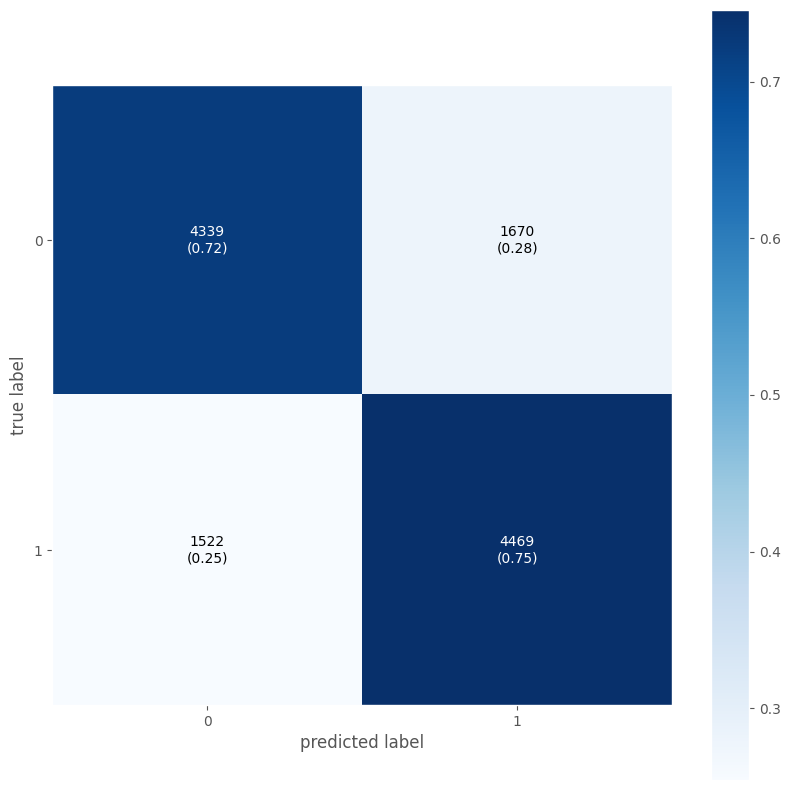

In [54]:
print('Confusion Matrix\n')
CR = confusion_matrix(y_test, y_pred)
print(CR)

fig, ax = plot_confusion_matrix(
    conf_mat=CR, figsize=(10, 10),
    show_absolute=True,
    show_normed=True,
    colorbar=True
)

plt.show()

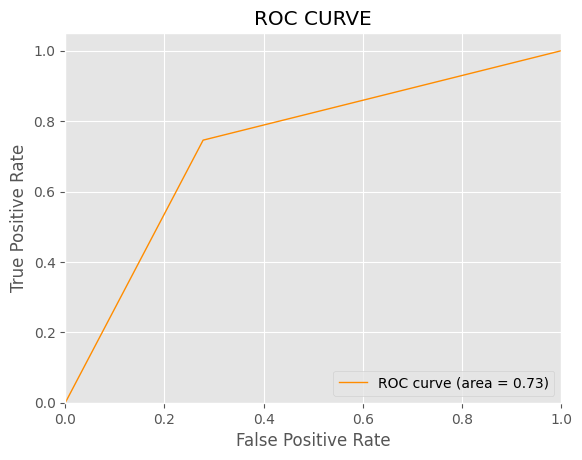

In [55]:
fpr, tpr, treshholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc='lower right')
plt.show()